# CS 445 Final Project: Video/Image Upsamling

### Setup

In [552]:
datadir = "./" 

utilfn = datadir + "utils.py"
imagesfn = datadir + "images"

In [553]:
import ffmpeg
import cv2
import numpy as np
import os
import numpy.linalg as la
import utils
%matplotlib inline
from matplotlib import pyplot as plt

from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

# Image Upsamling

### Read input image

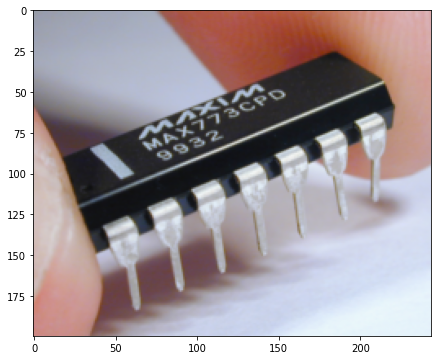

In [554]:
input_img_location = imagesfn + '/chip_input.png'
im1 = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure(figsize=(8,6))
plt.imshow(im1)
plt.show()

## 1. Initial Up-Sample using fast bicubic interpolation

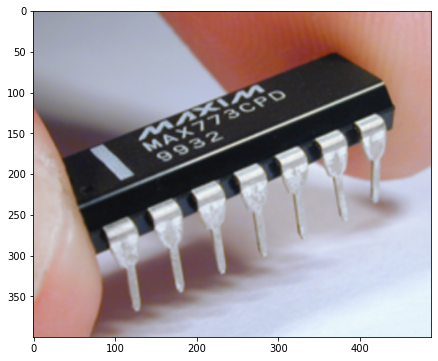

In [555]:
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)
plt.show()

## 2. Feedback-control upsamling

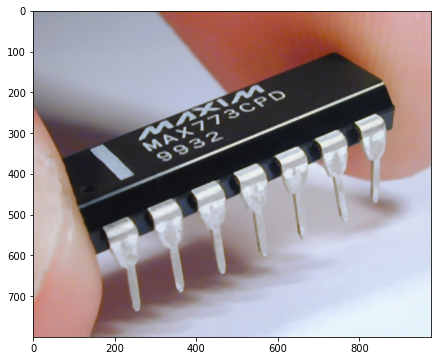

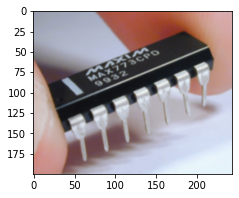

In [556]:
## test if method works using kernel we give
expect_loc = imagesfn + "/chip_10iter_s2.0_deconv0.03.png"
expect_im = cv2.cvtColor(cv2.imread(expect_loc), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure(figsize=(8, 6))
plt.imshow(expect_im)

# blur and down sample expect image using known kernal

sigma = 1.05
ksize = int(np.ceil(sigma)*5+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

down_sample_result = cv2.resize(cv2.filter2D(expect_im, -1, fil), None, fx=0.5, fy=0.5)
down_sample_result = cv2.resize(cv2.filter2D(down_sample_result, -1, fil), None, fx=0.5, fy=0.5)
plt.figure(figsize=(4, 3))
plt.imshow(down_sample_result)
plt.show()

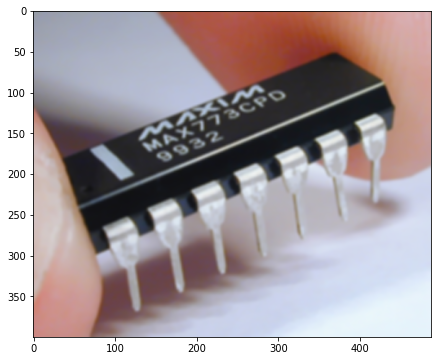

In [557]:
im1 = down_sample_result.copy()
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)
plt.show()

## Deconvolution
***
### Compute image gradient density 

Convert the RGB to YUV color space, and then upsample only the Y channel (Y value in range [16-235]). The UV channels are then upsampled to a higher resolution simply by a fast bicubic interpolation:

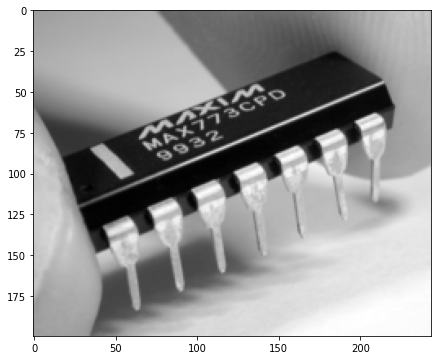

In [558]:
input_img_location = imagesfn + '/chip_input.png'
im1_YUV = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
im1_y, im1_u, im1_v = cv2.split(im1_YUV)
plt.figure(figsize=(8,6))
plt.imshow(im1_y, cmap='gray')
plt.show()

In [559]:
def compute_gradient(img):
    f1 = np.array([[-1], [0], [1]])
    f2 = np.array([[-1, 0, 1]])
    vert_gradient = cv2.filter2D(img, -1, f1)
    horz_gradient = cv2.filter2D(img, -1, f2)
    gradient = np.sqrt(np.square(vert_gradient) + np.square(horz_gradient))
    return gradient

In [560]:
def compute_gradient_xdir(img_y):
    f2 = np.array([[-1, 0, 1]])
    # f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T
    horz_gradient = cv2.filter2D(img_y, -1, f2)
    return horz_gradient


def compute_gradient_ydir(img_y):
    f1 = np.array([[-1], [0], [1]])
    # f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    vert_gradient = cv2.filter2D(img_y, -1, f1)
    return vert_gradient

In [561]:
gradient_xdir = compute_gradient_xdir(im1_y)
gradient_ydir = compute_gradient_ydir(im1_y)

In [562]:
grad_x_norm = cv2.normalize(gradient_xdir, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
grad_y_norm = cv2.normalize(gradient_ydir, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
grad_x_norm = grad_x_norm.astype(np.int16)
grad_y_norm = grad_y_norm.astype(np.int16)

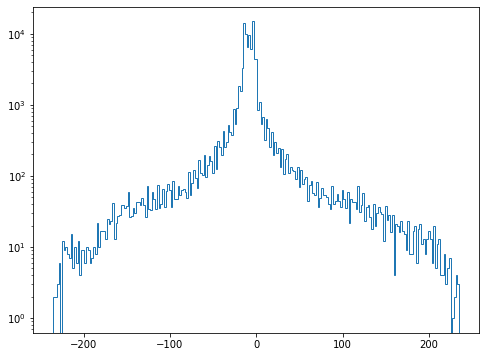

In [563]:
flatten_grad = grad_x_norm.flatten()
flatten_grad = np.append(flatten_grad, grad_y_norm.flatten())
plt.figure(figsize=(8, 6))
counts, bins, bars = plt.hist(flatten_grad, log=True, bins=235,range=(-235,235),facecolor="r", histtype = 'step')
plt.show()

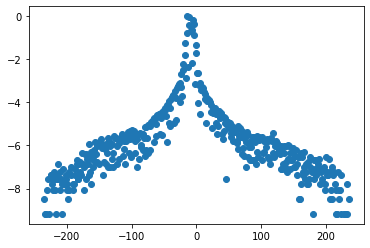

In [564]:
df = pd.Series(flatten_grad).value_counts().reset_index()
df.columns = ['val', 'count']
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.show()

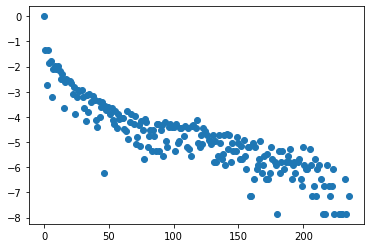

In [565]:
df = pd.Series(flatten_grad).value_counts().reset_index()
df.columns = ['val', 'count']
df = df[df['val'] >= 0]
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.show()

In [566]:
my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]
l_t = 13
print(l_t)

[  0.          33.99807577 235.        ]
13


In [567]:
def piecewise(x, k, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

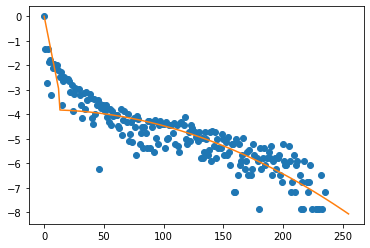

In [568]:
p , e = optimize.curve_fit(piecewise, val, log_count)
xd = np.linspace(0, 255, len(df['count']))
plt.plot(val,  log_count, "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [569]:
k, a, b = p[0], p[1], p[2]
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.2445643766, a=0.0000653186, b=3.8110664611: 


In [570]:
def calculate_phi(gradient_x, gradient_y):
    grad_norm_x = cv2.normalize(gradient_x, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
    grad_norm_y = cv2.normalize(gradient_y, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
    grad_norm_x = grad_norm_x.astype(np.int16)
    grad_norm_y = grad_norm_y.astype(np.int16)
    flattened_grad_x = grad_norm_x.flatten()
    flattened_grad = np.append(flattened_grad_x, grad_norm_y.flatten())
    df = pd.Series(flattened_grad).value_counts().reset_index()
    df.columns = ['val', 'count']
    df = df[df['val'] >= 0]
    val = np.array(df['val'])
    log_count = np.log(df['count'] / df['count'].max())
    my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
    breaks = my_pwlf.fit(2)
    l_t = breaks[1]

    def piecewise(x, k, a, b):
        return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

    p , e = optimize.curve_fit(piecewise, val, log_count)
    k, a, b = p[0], p[1], p[2]
    return l_t, k, a, b

In [571]:
l_t, k, a, b = calculate_phi(gradient_xdir, gradient_ydir)
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.1321683441, a=0.0000584524, b=4.0328696468: 


### Minimize Energy function

In [572]:
# transform filter to have same size as image version
input_img_location = imagesfn + '/chip_input.png'
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

H_prime_y, _, _ = cv2.split(bicubic_im_yuv)

sigma = 1.05
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

full_size_fil = np.zeros(H_prime_y.shape)
x_start = int((full_size_fil.shape[0] - fil.shape[0]) / 2)
y_start = int((full_size_fil.shape[1] - fil.shape[1]) / 2)
full_size_fil[x_start:x_start + fil.shape[0], y_start:y_start + fil.shape[1]] = fil
fil = full_size_fil.copy()

In [573]:
f_fft = np.fft.fft2(fil)
H_prime_fft = np.fft.fft2(H_prime_y)

In [574]:
H = H_prime_y.copy()  # assume gaussian filter does nothing
f1 = np.array([[-1], [0], [1]])
f2 = np.array([[-1, 0, 1]])
H_x_gradient = cv2.filter2D(H, -1, f2)
H_y_gradient = cv2.filter2D(H, -1, f1)

lambda_1 = 0.3
lambda_2 = 20

- $\mu$ Step: fix$H$to optimize $\mu$
$$ E(\mu) = \lambda_1\parallel \Phi(\mu_x) \parallel_1 + \ \lambda_2\parallel \mu_x - \partial_x H \parallel_2^{2}$$
***
$$ \partial_x H \geq l_t : E(\mu) = \lambda_1\parallel -k|\mu_x| \parallel_1 + \lambda_2 \parallel \mu_x - \partial_x H \parallel_2^2$$
***
To:
$$ \partial_x H \leq l_t : E(\mu) = \lambda_1| -k|\mu_x| | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
$$ \partial_x H < l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
To
$$ \partial_x H > l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
By solving $\partial E(\mu)/ \partial \mu = 0$, we have
$$ \partial H \geq l_t : \mu = \frac{2 \lambda_2 \partial H \pm \lambda_1 k}{2 \lambda_2}$$
***
$$ \partial H < l_t : \mu = \frac{2 \lambda_2 \partial H}{2 \lambda_1 a + 2 \lambda_2}$$

In [575]:
# 𝜇 step
def mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient):
    mu_x = np.zeros(H_x_gradient.shape)
    mu_y = np.zeros(H_y_gradient.shape)
    height,width = H_x_gradient.shape[:2]

    # since phi is calculated between 0 and 235
    k = k * 235
    a = a * (235 ** 2)
    for i in range(height):
        for j in range(width):
            curr_x_grad = H_x_gradient[i][j]
            curr_y_grad = H_y_gradient[i][j]

            if abs(curr_x_grad) < l_t:
                if curr_x_grad > 0:
                    mu_x[i][j] = ((2 * lambda_2 * curr_x_grad) - lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_x[i][j] = ((2 * lambda_2 * curr_x_grad) + lambda_1 * k) / (2 * lambda_2)
            else:
                mu_x[i][j] = (2 * lambda_2 * curr_x_grad) / (2 * lambda_1 * a + 2 * lambda_2)

            if abs(curr_y_grad) < l_t:
                if curr_y_grad > 0:
                    mu_y[i][j] = ((2 * lambda_2 * curr_y_grad) - lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_y[i][j] = ((2 * lambda_2 * curr_y_grad) + lambda_1 * k) / (2 * lambda_2)
            else:
                mu_y[i][j] = (2 * lambda_2 * curr_y_grad) / (2 * lambda_1 * a + 2 * lambda_2)

    return mu_x, mu_y


In [576]:
mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)

In [577]:
(mu_x - H_x_gradient).max()

0.2329467065261602

- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

In [578]:
def H_optimize(f_fft, H_prime_fft, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y):
    H_x_grad_fft = np.fft.fft2(H_x_gradient)
    H_y_grad_fft = np.fft.fft2(H_y_gradient)
    mu_x_fft = np.fft.fft2(mu_x)
    mu_y_fft = np.fft.fft2(mu_y)

    upper_adding = lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft
    lower_adding = lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft
    clip_upper = np.clip(upper_adding, -0.1, 0.1)
    clip_lower = np.clip(lower_adding, -0.1, 0.1)

    H_star_fft = ((np.conj(f_fft) * H_prime_fft) +clip_upper) / ((np.conj(f_fft) * f_fft) +clip_lower)
    H_star = np.fft.ifft2(H_star_fft)
    H_star = np.clip(np.real(H_star),0,1)

    shift_result = np.fft.fftshift(H_star,(0,1))
    return shift_result

In [579]:
H_star = H_optimize(f_fft, H_prime_fft, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

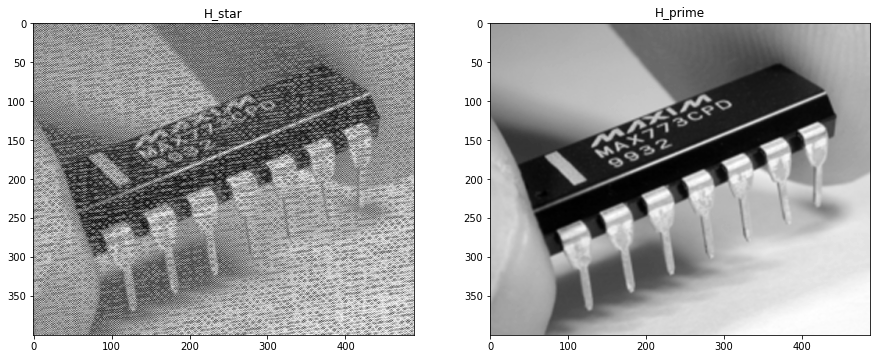

In [580]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star')
plt.imshow(H_star, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

In [581]:
for i in range(4):
    lambda_2 *= 3
    H = H_star.copy()
    H_x_gradient = cv2.filter2D(H, -1, f2)
    H_y_gradient = cv2.filter2D(H, -1, f1)
    mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
    H_star = H_optimize(f_fft, H_prime_fft,lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

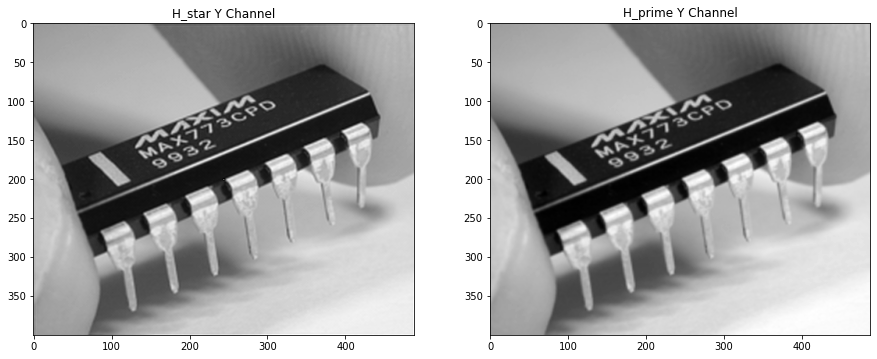

In [582]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star Y Channel')
plt.imshow(H_star, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

#### Show images in RGB

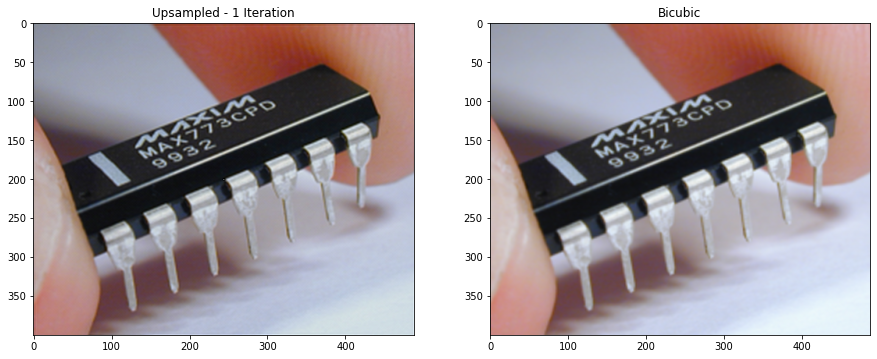

In [583]:
im_rgb = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
bicubic_im_rgb = cv2.resize(im_rgb, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# merge H_star with U and V channels upsampled with bicubic
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV)
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
_, bicubic_u, bicubic_v = cv2.split(bicubic_im_yuv)

# normalize H_start to 0-235 from 0-`
H_star_norm = cv2.normalize(H_star, None, alpha = 0, beta = 235, norm_type = cv2.NORM_MINMAX)
H_star_norm = H_star_norm.astype(bicubic_u.dtype)
merged_YUV = cv2.merge([H_star_norm, bicubic_u, bicubic_v])
merged_rgb = cv2.cvtColor(merged_YUV, cv2.COLOR_YUV2RGB)#.astype('double') / 255.0

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('Upsampled - 1 Iteration')
plt.imshow(merged_rgb)
plt.subplot(1,2,2)
plt.title('Bicubic')
plt.imshow(bicubic_im_rgb)
plt.show()


## Re-convolution
we need to refine $\tilde{H}$ by reinforcing the information obtained from L

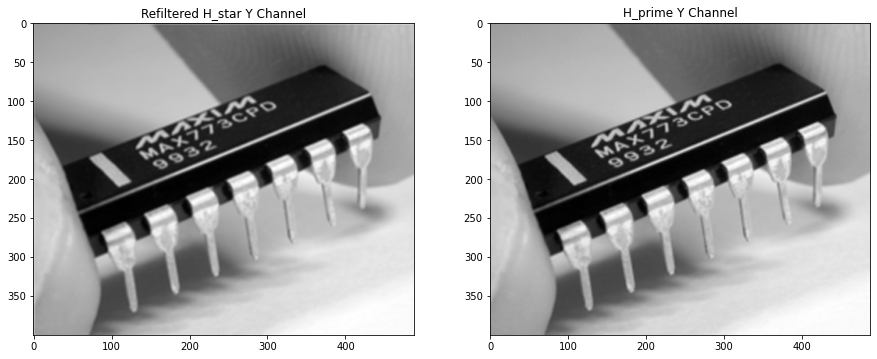

In [584]:
# should be close to bicubic iterpolated image(original h prime)
refil_im = cv2.filter2D(H_star, -1, fil)

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('Refiltered H_star Y Channel')
plt.imshow(refil_im, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

## Pixel Substitution

In [585]:
H_prime_refil = refil_im.copy()

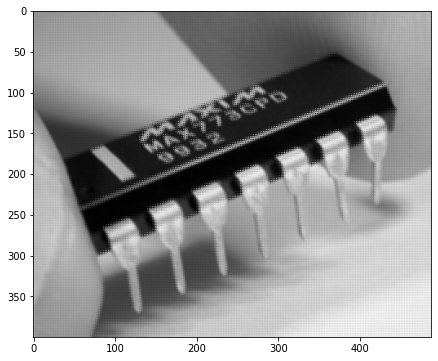

In [586]:
n = 2
for i in range(im1_y.shape[0]):
    for j in range(im1_y.shape[1]):
        H_prime_refil[n * i][n * j] = im1_y[i][j]

plt.figure(figsize=(8, 6))
plt.imshow(H_prime_refil, cmap='gray')

In [587]:
# H_prime_y = bicubic_im1.copy()
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
H_prime_y, _, _ = cv2.split(bicubic_im_yuv)

f1 = np.array([[-1], [0], [1]])
f2 = np.array([[-1, 0, 1]])

loop_iteration = 4

for i in range(loop_iteration):
    f_fft = np.fft.fft2(fil)
    H_prime_fft = np.fft.fft2(H_prime_y)

    H = H_prime_y.copy()  # assume gaussian filter does nothing

    lambda_1 = 0.3
    lambda_2 = 20

    for j in range(4):
        H_x_gradient = cv2.filter2D(H, -1, f2)
        H_y_gradient = cv2.filter2D(H, -1, f1)
        mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
        H_star = H_optimize(f_fft, H_prime_fft,lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)
        lambda_2 *= 3
        H = H_star.copy()

    refil_im = cv2.filter2D(H_star, -1, fil)
    H_prime_y = refil_im.copy()
    # H_prime_y = H_star.copy()

    n = 2
    for k in range(im1_y.shape[0]):
        for l in range(im1_y.shape[1]):
            H_prime_y[n * k][n * l] = im1_y[k][l]

    print('one iteration finished')

one iteration finished
one iteration finished
one iteration finished
one iteration finished


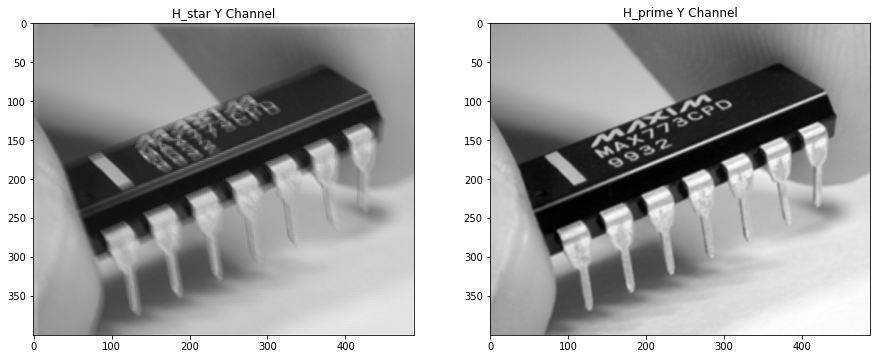

In [588]:
H_prime_y, _, _ = cv2.split(bicubic_im_yuv)
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star Y Channel')
plt.imshow(H_star, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

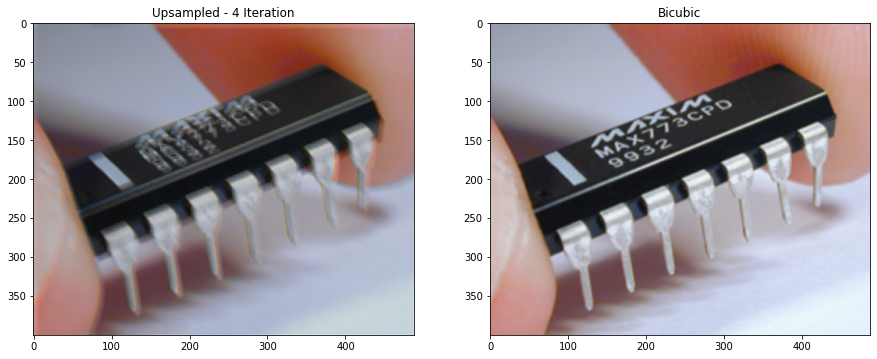

In [589]:
im_rgb = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
bicubic_im_rgb = cv2.resize(im_rgb, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# merge H_star with U and V channels upsampled with bicubic
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV)
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
_, bicubic_u, bicubic_v = cv2.split(bicubic_im_yuv)

# normalize H_start to 0-235 from 0-1
H_star_norm = cv2.normalize(H_star, None, alpha = 0, beta = 235, norm_type = cv2.NORM_MINMAX)
H_star_norm = H_star_norm.astype(bicubic_u.dtype)
merged_YUV = cv2.merge([H_star_norm, bicubic_u, bicubic_v])
merged_rgb = cv2.cvtColor(merged_YUV, cv2.COLOR_YUV2RGB)#.astype('double') / 255.0

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('Upsampled - 4 Iteration')
plt.imshow(merged_rgb)
plt.subplot(1,2,2)
plt.title('Bicubic')
plt.imshow(bicubic_im_rgb)
plt.show()


## 3. Final Output

# Video Upsamling